<a href="https://colab.research.google.com/github/ary3120-droid/myproject/blob/main/star0205.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##0. 데이터 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from google.colab import drive


drive.mount('/content/drive')

path = '/content/drive/MyDrive/star/'

portfolio = pd.read_json(path + 'portfolio.json', orient='records', lines=True)
profile = pd.read_json(path + 'profile.json', orient='records', lines=True)
transcript = pd.read_json(path + 'transcript.json', orient='records', lines=True)

print("데이터 로딩 성공!")
print(f"Portfolio: {portfolio.shape}, Profile: {profile.shape}, Transcript: {transcript.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
데이터 로딩 성공!
Portfolio: (10, 6), Profile: (17000, 5), Transcript: (306534, 4)


In [2]:
# 1. 한글 폰트 설치 (나눔바른고딕)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 2. 실행 후 [런타임 다시 시작] 을 눌러주세요!

# 3. 런타임 재시작 후 아래 코드로 설정 적용
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

##1. 전처리

In [32]:
# 1-1) Profile 정제: 118세 행 제거(팀 결정)
profile_clean = profile[profile['age'] != 118].copy()
profile_clean['became_member_on'] = pd.to_datetime(profile_clean['became_member_on'], format='%Y%m%d')

# 1-2) Transcript value 파싱(방어코드)
def get_val(x, key, default=None):
    if isinstance(x, dict):
        return x.get(key, default)
    return default

transcript = transcript.copy()
transcript['offer_id'] = transcript['value'].apply(lambda x: get_val(x,'offer_id') or get_val(x,'offer id'))
transcript['amount']   = transcript['value'].apply(lambda x: get_val(x,'amount', 0) or 0)
transcript['reward']   = transcript['value'].apply(lambda x: get_val(x,'reward', 0) or 0)

df_log = transcript.drop(columns=['value'])

# 1-3) Profile 조인: gender/income까지 포함(팀 합의 반영)
df_log = df_log.merge(
    profile_clean[['id','became_member_on','age','gender','income']],
    left_on='person', right_on='id', how='inner'
).drop(columns=['id'])

# 1-4) Portfolio 조인: reward 충돌 방지(offer_reward로 rename)
portfolio2 = portfolio.rename(columns={'id':'offer_id', 'reward':'offer_reward'})
df_log = df_log.merge(portfolio2, on='offer_id', how='left')

# 1-5) 중복 컬럼 안전 삭제(있을 때만)
for c in ['id_offer', 'person_offer']:
    if c in df_log.columns:
        df_log.drop(columns=[c], inplace=True)

# reward_offer가 생겼을 수도 있으니 동일하면 제거
if 'reward_offer' in df_log.columns:
    same = (df_log['reward'].fillna(-1) == df_log['reward_offer'].fillna(-1)).all()
    if same:
        df_log.drop(columns=['reward_offer'], inplace=True)

print("최종 전처리 및 조인 완료!")
print("df_log shape:", df_log.shape)


최종 전처리 및 조인 완료!
df_log shape: (272762, 15)


##2. 서비스 현황 파악 (EDA)

총 매출(transaction 합): $1,734,942
분석 대상 고객 수: 14,825명
ARPU: $117.03


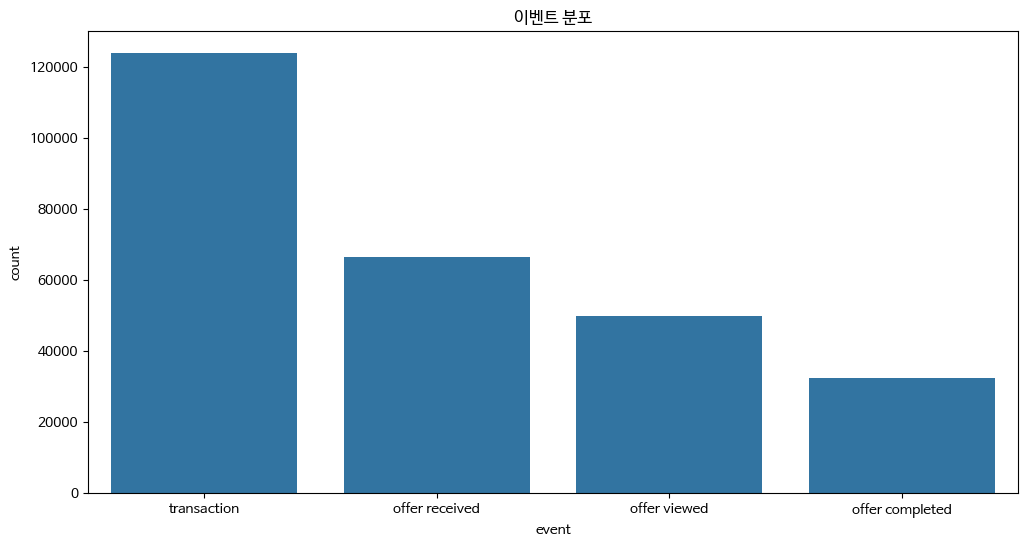

In [34]:
target_users = df_log['person'].nunique()

total_revenue = df_log.loc[df_log['event']=='transaction', 'amount'].sum()
avg_revenue_per_user = total_revenue / target_users

print(f"총 매출(transaction 합): ${total_revenue:,.0f}")
print(f"분석 대상 고객 수: {target_users:,}명")
print(f"ARPU: ${avg_revenue_per_user:.2f}")

plt.figure(figsize=(12,6))
order = df_log['event'].value_counts().index
ax = sns.countplot(data=df_log, x='event', order=order)
plt.title('이벤트 분포')
plt.show()


In [41]:
# [교체 ①] "오퍼 노출 100%" 셀 교체용
paying_users = set(df_log[df_log['event']=='transaction']['person'].unique())
users_received = set(df_log[df_log['event']=='offer received']['person'].unique())
users_completed = set(df_log[df_log['event']=='offer completed']['person'].unique())

print(f"전체 결제 고객: {len(paying_users):,}명")
print(f"오퍼 수령(노출) 고객: {len(users_received):,}명")
print(f"오퍼 완료(혜택/반응) 고객: {len(users_completed):,}명")

print(f"결제 고객 중 오퍼 노출(수령) 비중: {len(paying_users & users_received)/len(paying_users):.1%}")
print(f"결제 고객 중 오퍼 완료 비중: {len(paying_users & users_completed)/len(paying_users):.1%}")

# 거래 기준 지표(핵심): 오퍼 영향 거래 비중은 아래 [교체②]에서 tx_flag 만든 뒤 계산
print("\n※ 유저 기준 노출은 거의 100%가 될 수 있어요.")
print("※ 아래에서 '거래 기준 오퍼 영향 비중'을 메인 KPI로 봅니다.")


전체 결제 고객: 14,492명
오퍼 수령(노출) 고객: 14,820명
오퍼 완료(혜택/반응) 고객: 11,986명
결제 고객 중 오퍼 노출(수령) 비중: 100.0%
결제 고객 중 오퍼 완료 비중: 82.7%

※ 유저 기준 노출은 거의 100%가 될 수 있어요.
※ 아래에서 '거래 기준 오퍼 영향 비중'을 메인 KPI로 봅니다.


In [36]:
viewed_logs = (df_log[df_log['event']=='offer viewed']
              .groupby(['person','offer_id'])['time'].min()
              .reset_index(name='viewed_time'))

completed_logs = (df_log[df_log['event']=='offer completed']
                 .groupby(['person','offer_id'])['time'].min()
                 .reset_index(name='completed_time'))

check_flow = completed_logs.merge(viewed_logs, on=['person','offer_id'], how='left')

waste_cases = check_flow[
    check_flow['viewed_time'].isna() | (check_flow['viewed_time'] > check_flow['completed_time'])
]

print(f"총 완료(person-offer) 건수: {len(check_flow):,}")
print(f"waste 사례: {len(waste_cases):,} ({len(waste_cases)/len(check_flow):.1%})")


총 완료(person-offer) 건수: 27,942
waste 사례: 8,106 (29.0%)


In [48]:
# [수정 1] 오퍼 영향/오가닉 계산 셀 교체용 (거래당 최근 오퍼 1개만 매칭)

# offer window(수령~만료)
offers = df_log[df_log['event']=='offer received'][['person','offer_id','time','duration']].copy()
offers = offers.dropna(subset=['offer_id','duration'])
offers['offer_time'] = offers['time']
offers['expire_time'] = offers['offer_time'] + offers['duration']*24  # day -> hour

# transaction
tx = df_log[df_log['event']=='transaction'][['person','time','amount']].copy()

# 후보 매칭: 윈도우 안에 들어오는 경우만
cand = tx.merge(offers[['person','offer_id','offer_time','expire_time']], on='person', how='left')
cand = cand[(cand['time'] >= cand['offer_time']) & (cand['time'] <= cand['expire_time'])]

# 거래(person,time)별로 가장 최근 offer_time 1개만 선택
cand = cand.sort_values(['person','time','offer_time'])
cand_best = cand.groupby(['person','time'], as_index=False).tail(1)

# 거래 단위 오퍼 영향 플래그
tx_flag = tx.merge(
    cand_best[['person','time','offer_id']].assign(offer_influence=1),
    on=['person','time'], how='left'
)
tx_flag['offer_influence'] = tx_flag['offer_influence'].fillna(0).astype(int)
tx_flag['organic'] = (tx_flag['offer_influence'] == 0).astype(int)

print("오퍼 영향 거래 비중:", tx_flag['offer_influence'].mean())
print("오가닉 거래 비중:", tx_flag['organic'].mean())


오퍼 영향 거래 비중: 0.8782158329097993
오가닉 거래 비중: 0.12178416709020064


##3. 고객 세분화 (RFM + Clustering)

In [49]:
max_time = df_log['time'].max()

rfm = tx_flag.groupby('person').agg(
    Recency=('time', lambda x: max_time - x.max()),
    Frequency=('time', 'count'),
    Monetary=('amount', 'sum'),
    Organic_Count=('organic', 'sum')
)

rfm['Organic_Rate'] = rfm['Organic_Count'] / rfm['Frequency']

# 점수화
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)
rfm['RFM_Score'] = rfm['R_score'] + rfm['F_score'] + rfm['M_score']

display(rfm.head())


,Recency,Frequency,Monetary,Organic_Count,Organic_Rate,R_score,F_score,M_score,RFM_Score
person,,,,,,,,,
0009655768c64bdeb2e877511632db8f,18,8,127.60,0,0.000000,5,3,4,12
0011e0d4e6b944f998e987f904e8c1e5,60,5,79.46,1,0.200000,3,2,3,8
0020c2b971eb4e9188eac86d93036a77,6,8,196.86,2,0.250000,5,3,5,13
0020ccbbb6d84e358d3414a3ff76cffd,42,12,154.05,1,0.083333,4,4,4,12
003d66b6608740288d6cc97a6903f4f0,18,18,48.34,0,0.000000,5,5,2,12


###2. K-Means 군집화 (Clustering)



단순 점수 합계보다 더 정교한 분류를 위해 머신러닝 알고리즘인 K-Means를 적용

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

rfm_final = rfm.dropna(subset=['Organic_Rate']).copy()

X = rfm_final[['R_score','F_score','M_score','Organic_Rate']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm_final['Cluster'] = kmeans.fit_predict(X_scaled)

cluster_summary = rfm_final.reset_index().groupby('Cluster').agg(
    Recency=('Recency','mean'),
    Frequency=('Frequency','mean'),
    Monetary=('Monetary','mean'),
    Organic_Rate=('Organic_Rate','mean'),
    RFM_Score=('RFM_Score','mean'),
    고객수=('person','count')
)

display(cluster_summary.sort_values('RFM_Score', ascending=False))


,Recency,Frequency,Monetary,Organic_Rate,RFM_Score,고객수
Cluster,,,,,,
3,56.209742,11.434766,227.251786,0.096473,11.984336,5235
1,32.994734,10.892335,53.051080,0.101794,9.867466,3418
0,121.744856,4.423411,69.484508,0.516050,6.554641,2187
2,149.324754,4.707558,58.047122,0.054923,5.674699,3652


3. 결과 시각화

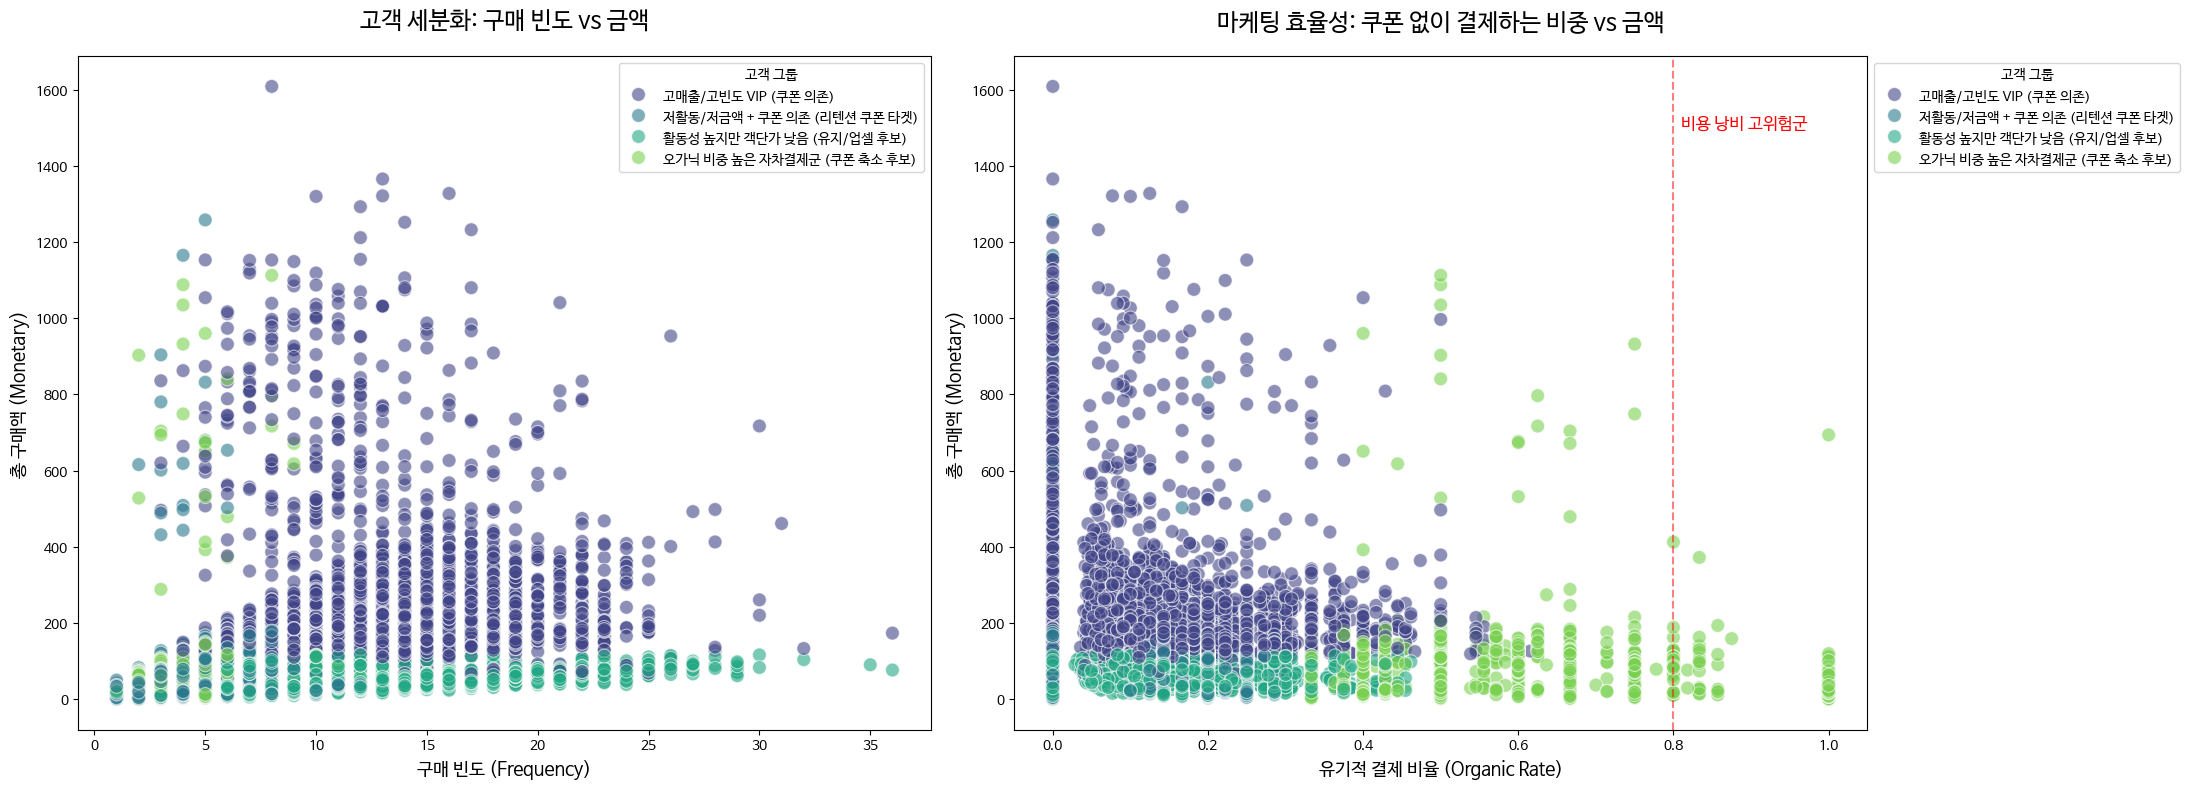

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 군집별 성격에 맞는 이름 부여 (분석 결과 기반)
# [수정 C] cluster 이름 재정의(현재 요약 통계에 맞춤)

cluster_names = {
    3: '고매출/고빈도 VIP (쿠폰 의존)',
    1: '활동성 높지만 객단가 낮음 (유지/업셀 후보)',
    0: '오가닉 비중 높은 자차결제군 (쿠폰 축소 후보)',
    2: '저활동/저금액 + 쿠폰 의존 (리텐션 쿠폰 타겟)'
}

rfm_final['Cluster_Name'] = rfm_final['Cluster'].map(cluster_names)


# 2. 시각화 설정 (서브플롯 활용)
fig, axes = plt.subplots(1, 2, figsize=(22, 8))

# 그래프 1: 고객 세분화 (구매 빈도 vs 총 구매액)
# 고객의 기본적인 활동성과 매출 기여도를 확인합니다.
sns.scatterplot(
    data=rfm_final, x='Frequency', y='Monetary', hue='Cluster_Name',
    ax=axes[0], palette='viridis', alpha=0.6, s=100
)
axes[0].set_title('고객 세분화: 구매 빈도 vs 금액', fontsize=17, pad=20)
axes[0].set_xlabel('구매 빈도 (Frequency)', fontsize=13)
axes[0].set_ylabel('총 구매액 (Monetary)', fontsize=13)
axes[0].legend(title='고객 그룹', bbox_to_anchor=(1, 1))

# 그래프 2: 마케팅 효율성 (유기적 결제 비중 vs 금액)
# 쿠폰 없이 결제하는 비중을 통해 마케팅 비용 절감 지점을 포착합니다.
sns.scatterplot(
    data=rfm_final, x='Organic_Rate', y='Monetary', hue='Cluster_Name',
    ax=axes[1], palette='viridis', alpha=0.6, s=100
)
axes[1].set_title('마케팅 효율성: 쿠폰 없이 결제하는 비중 vs 금액', fontsize=17, pad=20)
axes[1].set_xlabel('유기적 결제 비율 (Organic Rate)', fontsize=13)
axes[1].set_ylabel('총 구매액 (Monetary)', fontsize=13)
axes[1].legend(title='고객 그룹', bbox_to_anchor=(1, 1))

# 유기적 결제 비율 0.8 지점에 가이드라인 추가 (비용 낭비군 구분선)
axes[1].axvline(0.8, color='red', linestyle='--', alpha=0.5)
axes[1].text(0.81, 1500, '비용 낭비 고위험군', color='red', fontsize=12)

plt.tight_layout()
plt.show()

##4. 코호트 분석

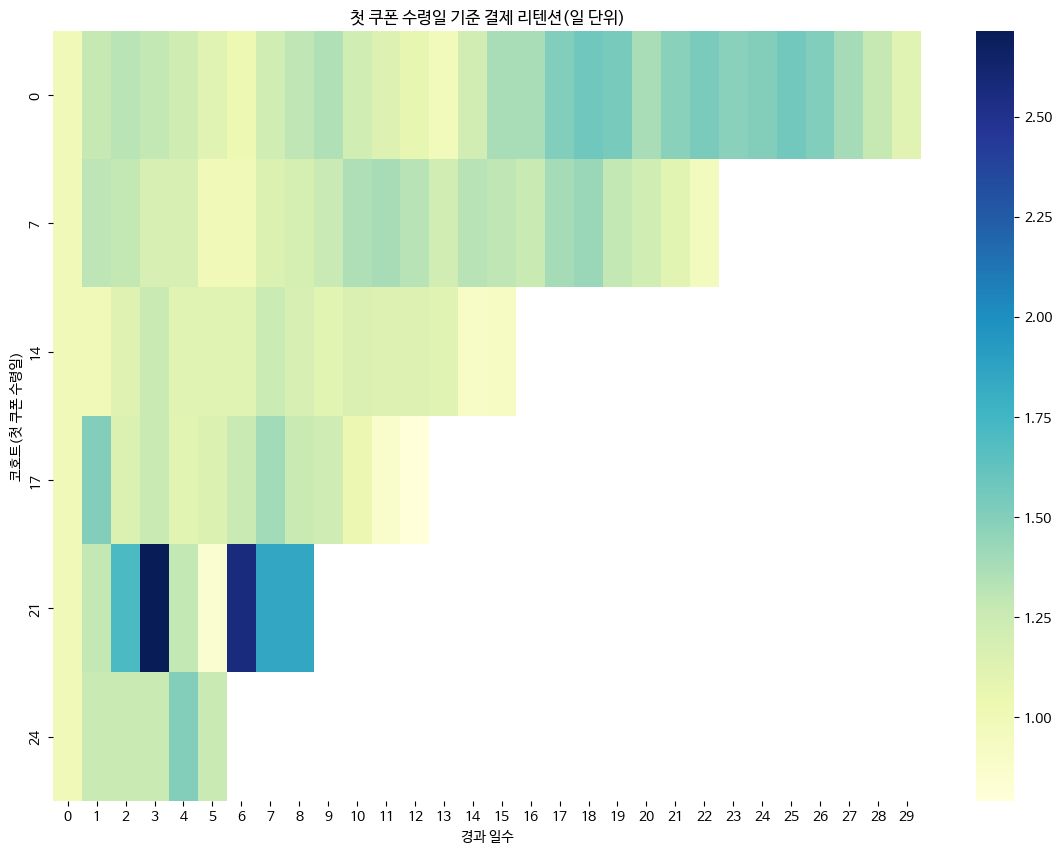

In [52]:
# 시간 → day
df_log['day'] = (df_log['time'] // 24).astype(int)

first_offer_day = (df_log[df_log['event']=='offer received']
                   .groupby('person')['day'].min()
                   .rename('cohort_day')
                   .reset_index())

tx_day = df_log[df_log['event']=='transaction'][['person','day']].copy()
tx_day = tx_day.merge(first_offer_day, on='person', how='inner')
tx_day['cohort_index'] = tx_day['day'] - tx_day['cohort_day']
tx_day = tx_day[tx_day['cohort_index'] >= 0]

cohort_counts = tx_day.groupby(['cohort_day','cohort_index'])['person'].nunique().reset_index()
cohort_pivot = cohort_counts.pivot(index='cohort_day', columns='cohort_index', values='person')
retention = cohort_pivot.divide(cohort_pivot.iloc[:,0], axis=0)

plt.figure(figsize=(14,10))
sns.heatmap(retention, annot=False, cmap='YlGnBu')
plt.title('첫 쿠폰 수령일 기준 결제 리텐션(일 단위)')
plt.xlabel('경과 일수')
plt.ylabel('코호트(첫 쿠폰 수령일)')
plt.show()


,Cluster,고객수,Recency,Frequency,Monetary,Organic_Rate
0,0,2187,121.744856,4.423411,69.484508,0.516050
1,1,3418,32.994734,10.892335,53.051080,0.101794
2,2,3652,149.324754,4.707558,58.047122,0.054923
3,3,5235,56.209742,11.434766,227.251786,0.096473


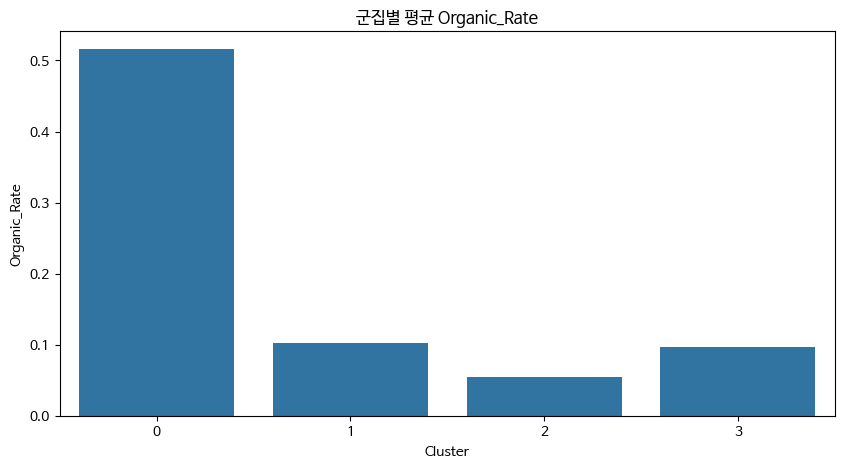

In [46]:
summary = rfm_final.reset_index().groupby('Cluster').agg(
    고객수=('person','count'),
    Recency=('Recency','mean'),
    Frequency=('Frequency','mean'),
    Monetary=('Monetary','mean'),
    Organic_Rate=('Organic_Rate','mean')
).reset_index()

display(summary)

plt.figure(figsize=(10,5))
sns.barplot(data=summary, x='Cluster', y='Organic_Rate')
plt.title('군집별 평균 Organic_Rate')
plt.show()


### ⑤ 이탈 예측 및 타겟팅 모델링

**1. 이탈 예측용 피처 엔지니어링 (Feature Engineering)**

머신러닝 모델이 학습할 수 있도록 고객별 데이터를 정제합니다.

**2. 모델 학습 및 성능 평가**

랜덤 포레스트(Random Forest) 모델을 사용하여 이탈 가능성을 예

In [56]:
# [수정 3] 이탈 예측/타겟팅 셀 교체용 (데이터 누수 제거)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 라벨: 최근 7일(168시간) 거래 없으면 이탈
rfm_final['Churn'] = (rfm_final['Recency'] > 7*24).astype(int)

# 누수 방지: Recency는 라벨 정의에 쓰였으므로 피처에서 제거
X = rfm_final[['R_score','F_score','M_score','Organic_Rate','Frequency','Monetary']]
y = rfm_final['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = RandomForestClassifier(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("--- [이탈 예측 모델 성능 평가(누수 제거)] ---")
print(classification_report(y_test, y_pred))

# 이탈 확률
rfm_final['Churn_Probability'] = model.predict_proba(X)[:, 1]

# 타겟: 이탈확률 높고 + 쿠폰 의존 높음
target_customers = rfm_final[
    (rfm_final['Churn_Probability'] > 0.7) &
    (rfm_final['Organic_Rate'] < 0.5)
]

print(f"전략적 쿠폰 발송 대상자: {len(target_customers):,}명")
display(target_customers.head())

# [최종] 타겟 요약(발표용)
print("\n[타겟 요약]")
print("타겟 수:", len(target_customers))
print("타겟 평균 Organic_Rate:", target_customers['Organic_Rate'].mean())
print("타겟 평균 Monetary:", target_customers['Monetary'].mean())
print("타겟 평균 Frequency:", target_customers['Frequency'].mean())
print("타겟 평균 Recency:", target_customers['Recency'].mean())

# cluster 분포(어디 군집이 타겟이 많은지)
print("\n[타겟의 Cluster 분포]")
display(target_customers['Cluster'].value_counts().sort_index())


--- [이탈 예측 모델 성능 평가(누수 제거)] ---
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2529
           1       0.70      0.69      0.70       370

    accuracy                           0.92      2899
   macro avg       0.83      0.83      0.83      2899
weighted avg       0.92      0.92      0.92      2899

전략적 쿠폰 발송 대상자: 1,310명


,Recency,Frequency,Monetary,Organic_Count,Organic_Rate,R_score,F_score,M_score,RFM_Score,Cluster,Cluster_Name,Churn,Churn_Probability
person,,,,,,,,,,,,,
008d7088107b468893889da0ede0df5c,264,7,16.18,1,0.142857,1,3,1,5,2,쿠폰 민감군 (핵심 타겟),1,0.970000
0091d2b6a5ea4defaa8393e4e816db60,174,12,279.16,0,0.000000,1,4,5,10,3,소액 충성군 (비용 낭비군),1,0.840000
00c32a104f0c4065b5b552895fb22e34,330,2,6.98,0,0.000000,1,1,1,3,2,쿠폰 민감군 (핵심 타겟),1,0.913333
00fbb9b5edb94f02afbaf1eb49bb4d7d,186,3,80.10,1,0.333333,1,1,3,5,0,최우수 VIP,1,0.983333
016871ea865d4338975026ae08d221d0,264,3,45.79,0,0.000000,1,1,2,4,2,쿠폰 민감군 (핵심 타겟),1,1.000000



[타겟 요약]
타겟 수: 1310
타겟 평균 Organic_Rate: 0.09469659687216939
타겟 평균 Monetary: 78.4803969465649
타겟 평균 Frequency: 5.0564885496183205
타겟 평균 Recency: 237.84274809160306

[타겟의 Cluster 분포]


,count
Cluster,
0,173
1,1
2,1020
3,116


3. 실무 활용: 타겟 고객 추출 (Actionable Insights)

In [55]:
# 전체 고객에 대해 이탈 확률 계산
rfm_final['Churn_Probability'] = model.predict_proba(X)[:, 1]

# 마케팅 효율화 타겟 조건:
# 1) 이탈 확률이 70% 이상이고
# 2) 유기적 결제 비율이 0.5 미만인 고객 (쿠폰에 반응할 사람)
target_customers = rfm_final[
    (rfm_final['Churn_Probability'] > 0.7) &
    (rfm_final['Organic_Rate'] < 0.5)
]

print(f"전략적 쿠폰 발송 대상자: {len(target_customers)}명")
display(target_customers.head())

전략적 쿠폰 발송 대상자: 1278명


,Recency,Frequency,Monetary,Organic_Count,Organic_Rate,R_score,F_score,M_score,RFM_Score,Cluster,Cluster_Name,Churn,Churn_Probability
person,,,,,,,,,,,,,
008d7088107b468893889da0ede0df5c,264,7,16.18,1,0.142857,1,3,1,5,2,쿠폰 민감군 (핵심 타겟),1,0.98
0091d2b6a5ea4defaa8393e4e816db60,174,12,279.16,0,0.000000,1,4,5,10,3,소액 충성군 (비용 낭비군),1,0.83
00c32a104f0c4065b5b552895fb22e34,330,2,6.98,0,0.000000,1,1,1,3,2,쿠폰 민감군 (핵심 타겟),1,0.90
00fbb9b5edb94f02afbaf1eb49bb4d7d,186,3,80.10,1,0.333333,1,1,3,5,0,최우수 VIP,1,0.99
016871ea865d4338975026ae08d221d0,264,3,45.79,0,0.000000,1,1,2,4,2,쿠폰 민감군 (핵심 타겟),1,1.00


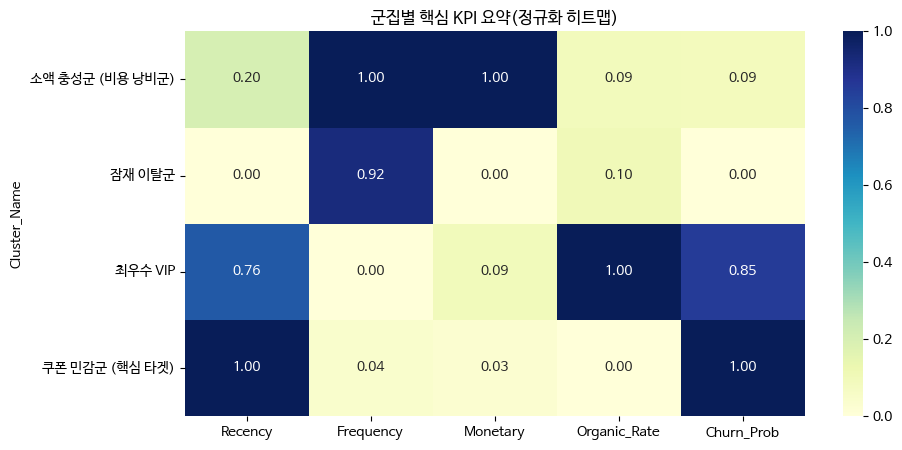

In [57]:
pivot = rfm_final.reset_index().groupby('Cluster_Name').agg(
    고객수=('person','count'),
    Recency=('Recency','mean'),
    Frequency=('Frequency','mean'),
    Monetary=('Monetary','mean'),
    Organic_Rate=('Organic_Rate','mean'),
    Churn_Prob=('Churn_Probability','mean')
)

plt.figure(figsize=(10,5))
sns.heatmap((pivot[['Recency','Frequency','Monetary','Organic_Rate','Churn_Prob']] -
             pivot[['Recency','Frequency','Monetary','Organic_Rate','Churn_Prob']].min()) /
            (pivot[['Recency','Frequency','Monetary','Organic_Rate','Churn_Prob']].max() -
             pivot[['Recency','Frequency','Monetary','Organic_Rate','Churn_Prob']].min()),
            annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("군집별 핵심 KPI 요약(정규화 히트맵)")
plt.show()
